# A Meta-Framework for Outlier Detection in Distributed Data

## FashionMNIST-Experiment

In [2]:
# import packages
import os
from tensorflow.keras.datasets import fashion_mnist, mnist
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

from torchvision import datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image

import syft as sy
sy.TorchHook(torch)

import numpy as np
import pandas as pd
import os

print(os.getcwd())

from src.local_and_global.evaluation import prc_ranks, get_rank_distance
from src.outlying_partition.evaluation import get_probabilities
from src.data.festool import create_federated_festool_dataset

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

/home/heyden/outlier_detection


ModuleNotFoundError: No module named 'src.data.festool'

### Define network size, batch size and learning rate

In [2]:
NUM_CLIENTS = 10
BATCH_SIZE = 64
LEARNING_RATE = 1e-3

DEVICES_WITH_LOCAL_OUTLIERS = [0]

Create a federated dataset

In [24]:

class Festool(torch.utils.data.Dataset):

    def __init__(self, data, targets):
        super(Festool, self).__init__()
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __get_item__(self, idx):
        return self.data[idx], self.targets[idx]


class FashionMnist(torch.utils.data.Dataset):

    def __init__(self,
                 data,
                 percentage_random_outliers: float,
                 subspace_fraction_random_outliers: float,
                 has_local_outliers: bool,
                 percentage_local_outliers: float,
                 subspace_fraction_local_outliers: float,
                 is_anomalous_cluster: bool,
                 subspace_fraction_anomalous_clusters: float,
                 transform=None):
        super(FashionMnist, self).__init__()

        self.percentage_random_outliers = percentage_random_outliers
        self.subspace_fraction_random_outliers = subspace_fraction_random_outliers
        self.has_local_outliers = has_local_outliers
        self.percentage_local_outliers = percentage_local_outliers
        self.subspace_fraction_local_outliers = subspace_fraction_local_outliers
        self.is_anomalous_cluster = is_anomalous_cluster
        self.subspace_fraction_anomalous_clusters = subspace_fraction_anomalous_clusters
        self.transform = transform
        self.data = data
        self.targets = np.zeros(shape=self.data.shape)

        self.__add_local_outliers__()
        # self.__add_global_outliers__()
        self.__add_random_outliers__()
        if is_anomalous_cluster:
            self.__make_anomalous_cluster()

    def __add_random_outliers__(self):
        for j, sample in enumerate(self.data):
            if np.random.uniform() < self.percentage_random_outliers:
                mask = np.random.binomial(n=1,
                                          p=self.subspace_fraction_random_outliers,
                                          size=sample.shape)
                outliers = np.random.uniform(size=sample.shape)
                self.data[j] = np.maximum(mask.astype(np.float32), sample)  # outliers[mask]
                self.targets[j] = 2*mask.astype(int)

    def __add_global_outliers__(self):
        (trainX, trainY), (testX, testY) = fashion_mnist.load_data()
        data = np.concatenate([trainX, testX]) / 255.0
        classes = np.concatenate([trainY, testY])
        outlier_candidates = data[classes == 5]
        outlier_candidates_indices = np.arange(len(outlier_candidates))
        for j, sample in enumerate(self.data):
            if np.random.uniform() < self.percentage_random_outliers:
                self.data[j] = outlier_candidates[np.random.choice(outlier_candidates_indices)]
                self.targets[j] = 2*np.ones(shape=sample.shape)

    def __add_local_outliers__(self):
        (trainX, trainY), (testX, testY) = fashion_mnist.load_data()
        data = np.concatenate([trainX, testX]) / 255.0
        classes = np.concatenate([trainY, testY])
        outlier_candidates = data[np.logical_or(classes == 7, classes == 3)]
        outlier_candidates_indices = np.arange(len(outlier_candidates))
        for j, sample in enumerate(self.data):
            if np.random.uniform() < self.percentage_local_outliers:
                outlier = outlier_candidates[np.random.choice(outlier_candidates_indices)]
                self.data[j] = outlier
                if self.has_local_outliers:
                    self.targets[j] = np.ones(self.targets[j].shape).astype(int)

    def __make_anomalous_cluster(self):
        self.data = self.data * -1 + 1
        self.targets = np.zeros(shape=self.data.shape, dtype=int) + 3

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        targets = self.targets[idx]
        if self.transform:
            sample = self.transform(sample.astype(np.float32))
        return sample, targets

In [25]:
class OneLayerAutoencoder(nn.Module):
    def __init__(self):
        super(OneLayerAutoencoder, self).__init__()
        self.enc = nn.Linear(in_features=784, out_features=32)
        self.dec = nn.Linear(in_features=32, out_features=784)

    def forward(self, x):
        x = F.relu(self.enc(x))
        x = torch.sigmoid(self.dec(x))
        return x


class MultiLayerAutoencoder(nn.Module):
    def __init__(self):
        super(MultiLayerAutoencoder, self).__init__()
        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=256)
        self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.enc3 = nn.Linear(in_features=128, out_features=64)
        self.enc4 = nn.Linear(in_features=64, out_features=32)
        self.enc5 = nn.Linear(in_features=32, out_features=16)
        # decoder
        self.dec1 = nn.Linear(in_features=16, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=128)
        self.dec4 = nn.Linear(in_features=128, out_features=256)
        self.dec5 = nn.Linear(in_features=256, out_features=784)
    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = F.relu(self.enc5(x))
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.sigmoid(self.dec5(x))
        return x


class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Some utility functions

In [26]:
# utility functions
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:1'
    else:
        device = 'cpu'
    return device


def make_dir():
    image_dir = 'FashionMNIST_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
        

def save_model(model, name):
    model_dir = 'FashionMNIST_MODELS'
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    torch.save(model.state_dict(), os.path.join(model_dir, name + ".pth"))
    

def load_model(name):
    model_path = os.path.join("FashionMNIST_MODELS", name + ".pth")
    state_dict = torch.load(model_path)
    if name.startswith("one_layer_ae"):
        model = OneLayerAutoencoder()
    if name.startswith("multi_layer_ae"):
        model = MultiLayerAutoencoder()
    if name.startswith("conv_ae"):
        model = ConvAutoencoder()
    model.load_state_dict(state_dict)
    return model

        
def save_decoded_image(img, comm, epoch, batch):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, './FashionMNIST_Images/linear_ae_image_{}_{}_{}.png'.format(comm, epoch, batch))


def get_averaged_weights(models):
    with torch.no_grad():
        result_state_dict = models[0].state_dict()
        layer_keys = result_state_dict.keys()
        for key in layer_keys:
            all_weights = [model.state_dict()[key] for model in models]
            result_state_dict[key] = torch.mean(torch.stack(all_weights), dim=0)
        return result_state_dict


print("Device is {}".format(get_device()))


def train(model, data, optimizer):
    recon = model(data)
    loss = criterion(recon, data)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return model, float(loss)

Device is cuda:1


### Data

- add outliers
- assign boolean labels to targets of mnist data set

In [ ]:
festool_data = create_federated_festool_dataset()
targets = [
    np.ones(data.shape) if i == 0 else np.zeros(data.shape) for i, data in enumerate(festool_data)
]
datasets = [Festool(festool_data[i], targets[i]) for i in range(len(targets))]

In [27]:
base_transforms_list = [
    transforms.ToPILImage(),
    transforms.RandomRotation(90, fill=(0,)),
    # transforms.Pad(padding=4),
    # transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
    transforms.ToTensor(),
]
base_transform = transforms.Compose(base_transforms_list)

(trainX, trainY), (testX, testY) = mnist.load_data()
data = np.concatenate([trainX, testX]) / 255.0
classes = np.concatenate([trainY, testY])
num_examples = len(data) - len(data) % (BATCH_SIZE*NUM_CLIENTS)
data_indices = np.arange(len(data))
np.random.shuffle(data_indices)
data = data[data_indices]
data = data[:num_examples]
newshape = (NUM_CLIENTS, int(num_examples/NUM_CLIENTS), data.shape[1], data.shape[2])
data = np.reshape(data, newshape)
federated_datasets = [
    FashionMnist(client_data,
                 percentage_random_outliers=0.01,
                 subspace_fraction_random_outliers=0.2,
                 has_local_outliers = client in DEVICES_WITH_LOCAL_OUTLIERS,
                 percentage_local_outliers = 0.01 if client in DEVICES_WITH_LOCAL_OUTLIERS else 0.2,
                 subspace_fraction_local_outliers=0.2,
                 is_anomalous_cluster=False,
                 subspace_fraction_anomalous_clusters=1.0,
                 transform=base_transform)
    for client, client_data in enumerate(data)
]
del data

plt.show()

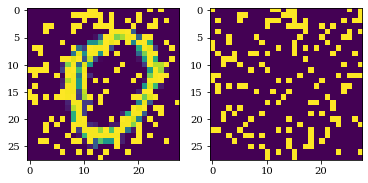

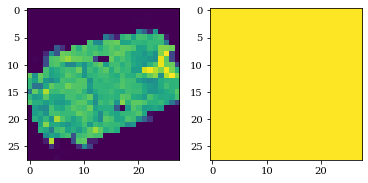

In [28]:
for data in federated_datasets[0]:
    img, targets = data
    if np.any(targets == 2):
        fig, axes = plt.subplots(1, 2)
        axes[0].imshow(img[0], vmin=0.0, vmax=1.0)
        axes[1].imshow(targets, vmin=0.0)
        plt.show()
        break

for data in federated_datasets[0]:
    img, targets = data
    if np.any(targets == 1):
        fig, axes = plt.subplots(1, 2)
        axes[0].imshow(img[0], vmin=0.0, vmax=1.0)
        axes[1].imshow(targets, vmin=0)
        plt.show()
        break

In [29]:
# CONFIGURATION
COMMUNICATION_ROUNDS = 5
LOCAL_EPOCHS = 2
MODEL_NAME = "one_layer_ae"

# CREATE MODEL, FEDERATE DATA AND MODELS
if MODEL_NAME == "one_layer_ae":
    base_model = OneLayerAutoencoder()
if MODEL_NAME == "multi_layer_ae":
    base_model = MultiLayerAutoencoder()
if MODEL_NAME == "conv_ae":
    base_model = ConvAutoencoder()

base_model.to(get_device())
base_model.train()
models_federated = [base_model.copy() for _ in range(NUM_CLIENTS)]
models_local = [base_model.copy() for _ in range(NUM_CLIENTS)]
base_model_federated = base_model.copy()  # this instance will be redistributed from server to clients

outlying_devices = []

# CREATE DATA LOADER FOR EACH CLIENT
data_loaders = [torch.utils.data.DataLoader(subset, batch_size=BATCH_SIZE, shuffle=True)
                for subset in federated_datasets]

# for batch in data_loaders[0]:
#     img, _ = batch
#     plt.imshow(img[0][0])
#     plt.show()

# THE CRITERION
criterion = nn.MSELoss()

# CREATE OPTIMIZER INSTANCE FOR EACH MODEL THAT WE TRAIN
optimizers_federated = [
    torch.optim.Adam(models_federated[i].parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
    for i in range(NUM_CLIENTS)
]
optimizers_local = [
    torch.optim.Adam(models_local[i].parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
    for i in range(NUM_CLIENTS)
]

for client in outlying_devices:
    client_data = data_loaders[client].dataset
    data_loaders[client] = DataLoader(client_data, batch_size=BATCH_SIZE, shuffle=True)

# FIT THE OUTLIER DETECTORS
loss_df = []

for comm_round in range(COMMUNICATION_ROUNDS):
    for client in range(NUM_CLIENTS):
        loader = data_loaders[client]
        model_c = models_federated[client]
        model_l = models_local[client]
        optimizer_c = optimizers_federated[client]
        optimizer_l = optimizers_local[client]
        for epoch in range(LOCAL_EPOCHS):
            for batch_idx, data in enumerate(loader):
                img = data[0]
                img = img.to(get_device(), dtype=torch.float)
                if not MODEL_NAME == "conv_ae":
                    img = img.view(img.size(0), img.size(1)*img.size(2)*img.size(3))
                model_c, loss_c = train(model_c, img, optimizer_c)
                model_l, loss_l = train(model_l, img, optimizer_l)
                models_federated[client] = model_c
                models_local[client] = model_l
                if batch_idx == 0:
                    print('Comm round {}, Client {}, Epoch:{}, Batch:{}, Loss_c:{:.4f}, Loss_l:{:.4f}'
                          .format(comm_round+1, 
                                  client+1,
                                  epoch+1, 
                                  batch_idx+1, 
                                  loss_c, 
                                  loss_l))
                    if client == 0:
                        save_decoded_image(img, comm_round, epoch, batch_idx)
                loss_df.append([client, comm_round, epoch, batch_idx, client in outlying_devices, loss_c])
    new_state_dict = get_averaged_weights(models_federated)
    base_model_federated.load_state_dict(new_state_dict)
    models_federated = [base_model_federated.copy() for _ in range(NUM_CLIENTS)]
    optimizers = [
        torch.optim.Adam(models_federated[i].parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
        for i in range(NUM_CLIENTS)
    ]

Comm round 1, Client 1, Epoch:1, Batch:1, Loss_c:0.2324, Loss_l:0.2324
Comm round 1, Client 1, Epoch:2, Batch:1, Loss_c:0.0696, Loss_l:0.0696
Comm round 1, Client 2, Epoch:1, Batch:1, Loss_c:0.2238, Loss_l:0.2238
Comm round 1, Client 2, Epoch:2, Batch:1, Loss_c:0.0826, Loss_l:0.0826
Comm round 1, Client 3, Epoch:1, Batch:1, Loss_c:0.2273, Loss_l:0.2273
Comm round 1, Client 3, Epoch:2, Batch:1, Loss_c:0.0751, Loss_l:0.0751
Comm round 1, Client 4, Epoch:1, Batch:1, Loss_c:0.2233, Loss_l:0.2233
Comm round 1, Client 4, Epoch:2, Batch:1, Loss_c:0.0726, Loss_l:0.0726
Comm round 1, Client 5, Epoch:1, Batch:1, Loss_c:0.2207, Loss_l:0.2207
Comm round 1, Client 5, Epoch:2, Batch:1, Loss_c:0.0770, Loss_l:0.0770
Comm round 1, Client 6, Epoch:1, Batch:1, Loss_c:0.2266, Loss_l:0.2266
Comm round 1, Client 6, Epoch:2, Batch:1, Loss_c:0.0768, Loss_l:0.0768
Comm round 1, Client 7, Epoch:1, Batch:1, Loss_c:0.2260, Loss_l:0.2260
Comm round 1, Client 7, Epoch:2, Batch:1, Loss_c:0.0805, Loss_l:0.0805
Comm r

### Model training

### Store models

In [30]:
save_model(base_model_federated, MODEL_NAME + "_c")
[save_model(model, MODEL_NAME + "_l_{}".format(i)) for i, model in enumerate(models_local)]
[torch.save(loader, os.path.join("FashionMNIST_MODELS", "loader_{}.pth".format(i))) for i, loader in enumerate(data_loaders)]

[None, None, None, None, None, None, None, None, None, None]

## Evaluation

### Load models

First we reload the previously trained models and the data loaders.
Note that the `base_model_federated` is sufficient, as *C* is identical for all clients

In [31]:
base_model_federated = load_model(MODEL_NAME + "_c")
models_local = [load_model(MODEL_NAME + "_l_{}".format(i)) for i in range(NUM_CLIENTS)]
data_loaders = [torch.load(os.path.join("FashionMNIST_MODELS", "loader_{}.pth".format(i))) for i in range(NUM_CLIENTS)]

[model.eval() for model in models_local]
base_model_federated.eval()

OneLayerAutoencoder(
  (enc): Linear(in_features=784, out_features=32, bias=True)
  (dec): Linear(in_features=32, out_features=784, bias=True)
)

## Global and local outliers

### Compute outlier scores

Let us first compute the outlier scores (mean squared error) for all images we trained on.

In [32]:
criterion = nn.MSELoss()
outlier_scores_c = []
outlier_scores_l = []
ground_truth = []
with torch.no_grad():
    for client in range(NUM_CLIENTS):
        print("Inferencing on client {}".format(client))
        model_c = base_model_federated.to(get_device())
        model_l = models_local[client].to(get_device())
        for batch_idx, batch in enumerate(data_loaders[client]):
            data, targets = batch
            data = data.to(get_device(), dtype=torch.float)
            if not MODEL_NAME == "conv_ae":
                data = data.view(data.shape[0], -1)
            pred_c = model_c(data)
            pred_l = model_l(data)
            os_c = [float(criterion(recon, original)) for recon, original in zip(pred_c, data)]
            os_l = [float(criterion(recon, original)) for recon, original in zip(pred_l, data)]
            outlier_scores_c += list(os_c)
            outlier_scores_l += list(os_l)
            ground_truth += list(targets.numpy())
outlier_scores_c = np.array(outlier_scores_c)
outlier_scores_l = np.array(outlier_scores_l)

Inferencing on client 0
Inferencing on client 1
Inferencing on client 2
Inferencing on client 3
Inferencing on client 4
Inferencing on client 5
Inferencing on client 6
Inferencing on client 7
Inferencing on client 8
Inferencing on client 9


In [33]:
ground_truth = np.array(ground_truth)

We check the mean outlier scores of in- and outliers:

In [34]:
is_normal = np.any(ground_truth == 0, axis=(-1, -2))
is_local_outlier = np.any(ground_truth == 1, axis=(-1, -2))
is_global_outlier = np.any(ground_truth == 2, axis=(-1, -2))
print(np.any(is_normal))
print(np.any(is_local_outlier))
print(np.any(is_global_outlier))

True
True
True


In [35]:
mean_os_normal_c = np.mean(outlier_scores_c[is_normal])
mean_os_local_outliers_c = np.mean(outlier_scores_c[is_local_outlier])
mean_os_global_outliers_c = np.mean(outlier_scores_c[is_global_outlier])

mean_os_normal_l = np.mean(outlier_scores_l[is_normal])
mean_os_local_outliers_l = np.mean(outlier_scores_l[is_local_outlier])
mean_os_global_outliers_l = np.mean(outlier_scores_l[is_global_outlier])

print("OS_C of inliers:  {:.4f}".format(mean_os_normal_c))
print("OS_C of local outliers: {:.4f}".format(mean_os_local_outliers_c))
print("OS_C of global outliers: {:.4f}".format(mean_os_global_outliers_c))

print("OS_L of inliers:  {:.4f}".format(mean_os_normal_l))
print("OS_L of local outliers: {:.4f}".format(mean_os_local_outliers_l))
print("OS_L of global outliers: {:.4f}".format(mean_os_global_outliers_l))

OS_C of inliers:  0.0630
OS_C of local outliers: 0.0687
OS_C of global outliers: 0.1740
OS_L of inliers:  0.0321
OS_L of local outliers: 0.0598
OS_L of global outliers: 0.1448


Text(27.125, 0.5, 'MSE')

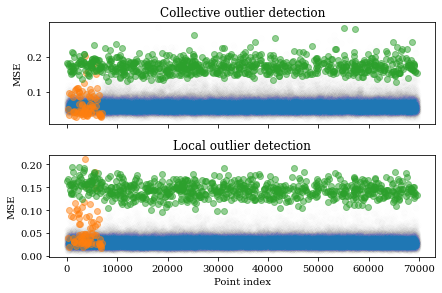

In [36]:
data_indices = np.array([i for i in range(len(outlier_scores_c))])
inlier_indices = data_indices[is_normal]
local_outlier_indices = data_indices[is_local_outlier]
global_outlier_indices = data_indices[is_global_outlier]

fig, axes = plt.subplots(2, 1, sharex="all")
axes[0].scatter(np.array([i for i in range(len(outlier_scores_c))])[inlier_indices], 
                outlier_scores_c[inlier_indices], 
                alpha=0.005)
axes[0].scatter(np.array([i for i in range(len(outlier_scores_c))])[local_outlier_indices], 
                outlier_scores_c[local_outlier_indices], 
                alpha=0.5)
axes[0].scatter(np.array([i for i in range(len(outlier_scores_c))])[global_outlier_indices], 
                outlier_scores_c[global_outlier_indices], 
                alpha=0.5)
axes[0].set_title("Collective outlier detection")
axes[1].scatter(np.array([i for i in range(len(outlier_scores_c))])[inlier_indices], 
                outlier_scores_l[inlier_indices], 
                alpha=0.005)
axes[1].scatter(np.array([i for i in range(len(outlier_scores_c))])[local_outlier_indices], 
                outlier_scores_l[local_outlier_indices], 
                alpha=0.5)
axes[1].scatter(np.array([i for i in range(len(outlier_scores_c))])[global_outlier_indices], 
                outlier_scores_l[global_outlier_indices], 
                alpha=0.5)
axes[1].set_title("Local outlier detection")
plt.tight_layout()
plt.xlabel("Point index")
axes[0].set_ylabel("MSE")
axes[1].set_ylabel("MSE")

In [46]:
labels = np.max(ground_truth, axis=(-1, -2))
rank_distances = get_rank_distance(os_c=outlier_scores_c, os_l=outlier_scores_l, labels=labels, beta=0.01)
prc_ranks_local = prc_ranks(os_c=outlier_scores_c, os_l=outlier_scores_l, labels=labels, pos_label=1)
prc_ranks_global = prc_ranks(os_c=outlier_scores_c, os_l=outlier_scores_l, labels=labels, pos_label=2)

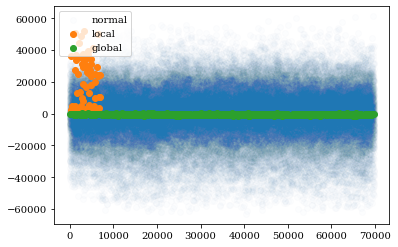

In [47]:
indices = np.arange(len(rank_distances))
plt.scatter(indices[labels==0], rank_distances[labels==0], alpha=0.01, label="normal")
plt.scatter(indices[labels==1], rank_distances[labels==1], label="local")
plt.scatter(indices[labels==2], rank_distances[labels==2], label="global")
plt.legend()
plt.show()

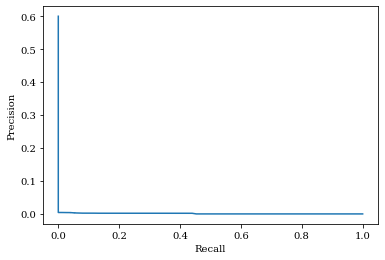

In [48]:
plt.plot(prc_ranks_local[1], prc_ranks_local[0])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

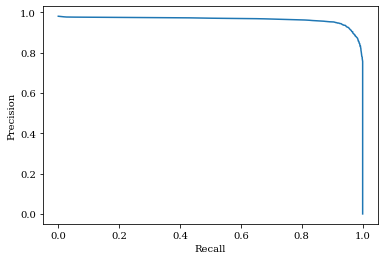

In [49]:
plt.plot(prc_ranks_global[1], prc_ranks_global[0])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

In [50]:
anomalous_cluster_scores = get_probabilities(outlier_scores_c)

NameError: name 'zscore' is not defined